In [41]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import matplotlib.mlab as mlab

from decimal import Decimal



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [43]:
Iona = (-123.30898284912109, 49.187351226806641)
S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

x0 = xl [0]
x1 = xl[0]
y0 = yl [0]
y1 = yl [1]
lower_left = (xl[0], yl[0])

In [58]:
#Parameters

cmap = plt.get_cmap('nipy_spectral')
cmap.set_bad('burlywood')

H = 24 #One day in hours

#Ariane parameters
tunit= 3600

outint = 20 * 60 # 20 min in seconds

pph = int(tunit / outint) #points per hour

lmt = 1896 #points per particle


#RUN parameters


basedir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2/2016+jan2017/"

plotsdir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/plots"

filesdir = "/ocean/gsgarbi/selected_days/"


position = nday * pph * H # d * num/h * h/d = num

In [45]:
def lin_equ(l1,l2):
    #line encoded as l=(x,y)
    if l2[0] == l1[0]:
        m = 0
        return m, l2[1]-(m*l2[0])
    m=((l2[1]-l1[1]))/(l2[0]-l1[0])
    c=(l2[1]-(m*l2[0]))
    return float(m), float(c)

In [71]:
def create_array(filesdir, nday):
    
    dirs = os.listdir(filesdir)

    dirs.sort()

    pts = []

    for i in dirs:
        
        if str(nday)+"d" in i: #select length

            array = np.load(open(filesdir + i, 'rb'))

            pts.append(array)

    pts = np.array([i for sublist in pts for i in sublist])

    
    return pts

<b> Load year 2016 </b>

In [72]:
array = create_array(filesdir, 10)

In [54]:
# areas_test = {"a1": [-200, 200, 49.1, 49.35]}

def separate_points (pts):
    



    df=pd.DataFrame(data=pts[:,1:],index=pts[:,0],columns=['Lon','Lat','Z','tind'])

    total = df

    points = {'alltop': [[x0, 51], [x0, 51]],
              'NB': [[x0,50.4], [-124.5, y1]],
                'N1': [[x0, 48], [-123.5, 50]],
                'N0': [[x0, Iona[0]], [x1, Iona[1]]],    
                    'S0': [[x0, 48.8], [x0, 48.8]],
                         'JF': [[x0, 46], [x0, 46]]
             }

    coefs = {}

    names = list(points.keys())

    for region in points.keys():
        coefs [region] = lin_equ(points[region][0], points[region][1])

    areas = {}
    for i in range(1, len(points.keys())):
        areas [names[i]] = df[ (df.Lat > coefs [names[i]][0] * df.Lon + coefs [names[i]][1]) &
                                    (df.Lat < coefs [names[i-1]][0] * df.Lon + coefs [names[i-1]][1]) ]

    df = areas['JF']
    areas['LB'] = df[(df.Lon < -124.7)]
    areas['JF'] = df[(df.Lon > -124.7)]
    
    return areas


In [55]:
separate_points(array)

{'JF':               Lon       Lat          Z     tind
 1315.0 -123.00770  48.66145   -3.39988  0.02545
 322.0  -123.05490  48.72535  -15.24589  0.02597
 323.0  -122.91397  48.79072  -36.90949  0.02597
 326.0  -122.98594  48.67787   -5.33438  0.02597
 556.0  -123.01667  48.67591  -34.13080  0.02597
 718.0  -123.05156  48.45968  -50.89046  0.02597
 721.0  -123.28990  48.64604  -55.69974  0.02597
 2150.0 -123.16576  48.75682  -11.14647  0.02597
 2154.0 -123.00244  48.75862   -6.73576  0.02597
 1.0    -123.16767  48.70922   -7.54333  0.02825
 27.0   -123.00982  48.77613  -20.93671  0.02825
 30.0   -123.14772  48.63119  -60.74035  0.02825
 33.0   -123.20949  48.69832  -31.69576  0.02825
 39.0   -123.00723  48.75354  -14.88750  0.02825
 45.0   -123.31091  48.52598  -25.75856  0.02825
 48.0   -122.88308  48.78575 -136.62909  0.02825
 57.0   -122.93728  48.77063  -34.68214  0.02825
 58.0   -122.87016  48.77855  -70.12401  0.02825
 69.0   -122.91907  48.73321  -26.49258  0.02825
 72.0   -123.0

In [90]:
def plot(points, title = 'title', picname = "noname"):
    
    Iona = (-123.30898284912109, 49.187351226806641)
    S15 = (-123.3114, 49.130412)
    S16 = (-123.317415, 49.1214)
    xl=(-126.2,-122.2)
    yl=(47.1,51)
    




    #prepare plot and constants
    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)
#     np.shape(points)
    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape
#     np.shape(points)[0]


    griddata, iedges, jedges = np.histogram2d(points['Lon'],points['Lat'],bins=[100,200],
                                                  range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(9,8))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0, vmax = vmax)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    
    axs.set_title( title + "\n Total of trajectories: {}".format( int(np.sum(griddata)) ) )
    
    el = Ellipse((2, -1), 0.5, 0.5)

    axs2.annotate(
            "IONA",
            xy=(Iona[0], Iona[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = (0.937, 0.439, 0.043),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"))
    
    return np.sum(griddata)

    

    


start:  2017-06-15 11:16:32.469472


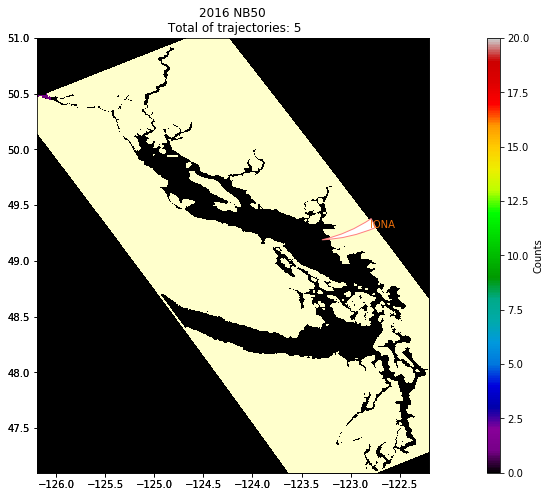

start:  2017-06-15 11:16:33.080257


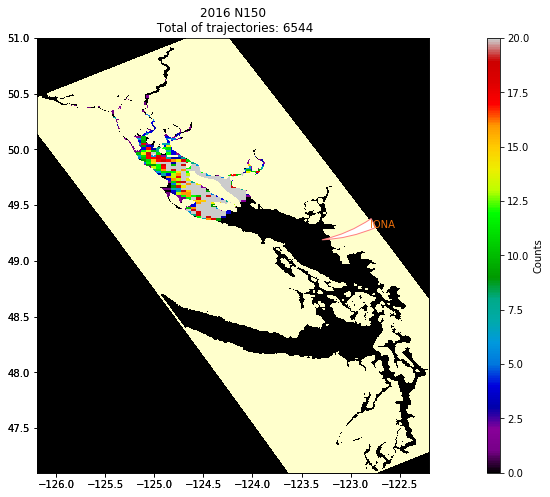

start:  2017-06-15 11:16:33.653067


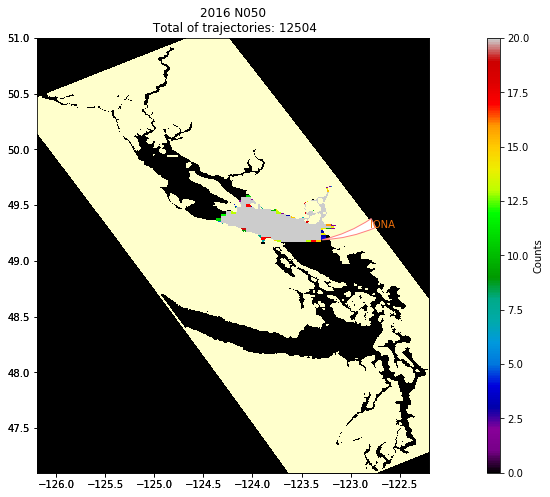

start:  2017-06-15 11:16:34.252016


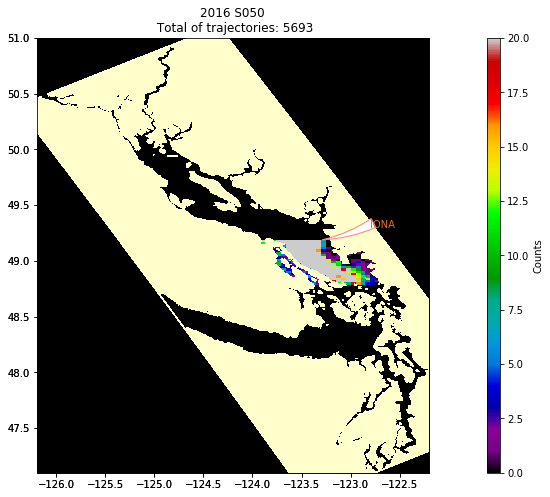

start:  2017-06-15 11:16:34.819434


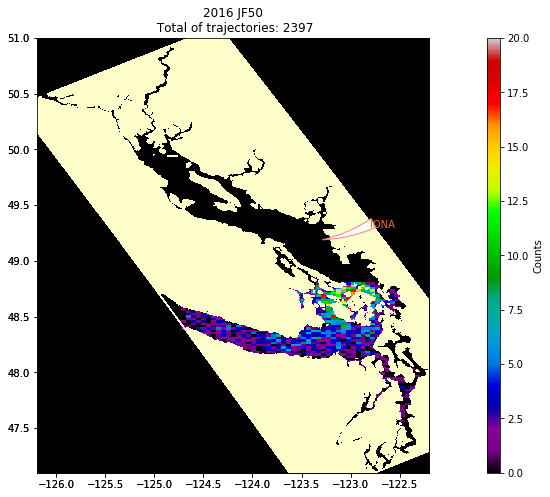

start:  2017-06-15 11:16:35.430686


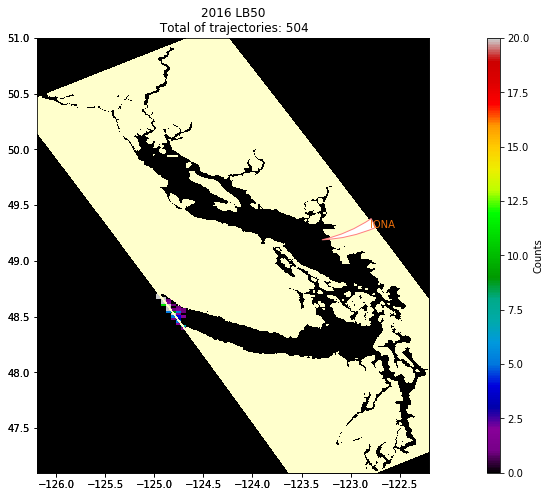

Sums for 50d per area:  {'NB': 5.0, 'N1': 6544.0, 'N0': 12504.0, 'S0': 5693.0, 'JF': 2397.0, 'LB': 504.0}


In [91]:
nday = 50

year_array = create_array(filesdir, nday)

areas = separate_points(year_array)
        


sums = {}
for area in areas.keys():

    title = ('2016 ' + area + str(nday)
    )

    sums [area] = plot(areas[area], title, "ok")
    
    plt.show()

plt.clf()

print ("Sums for {}d per area: ".format(nday), sums)

time_series = {}
time_series [nday] = sums
    

start:  2017-06-15 11:06:38.659589


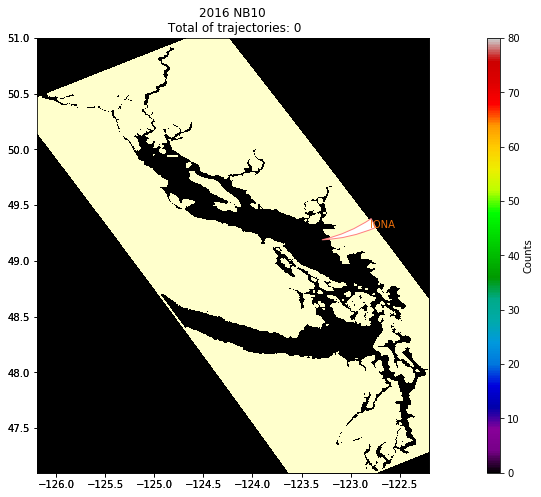

start:  2017-06-15 11:06:39.237905


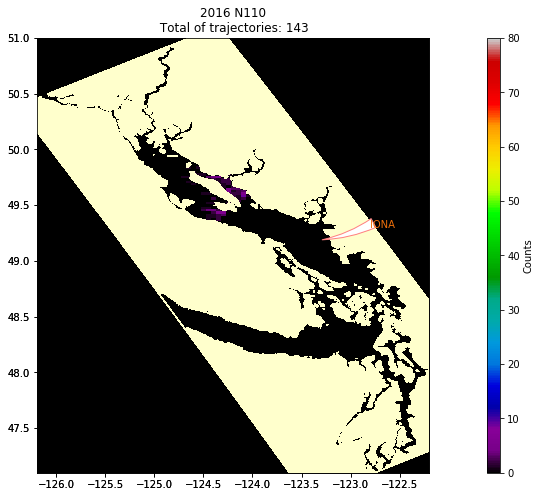

start:  2017-06-15 11:06:39.888642


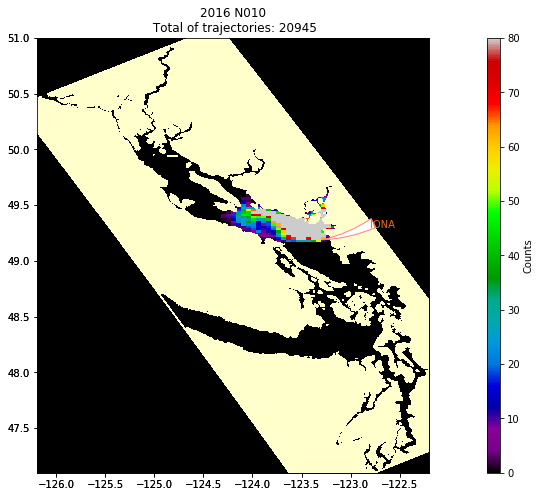

start:  2017-06-15 11:06:40.480219


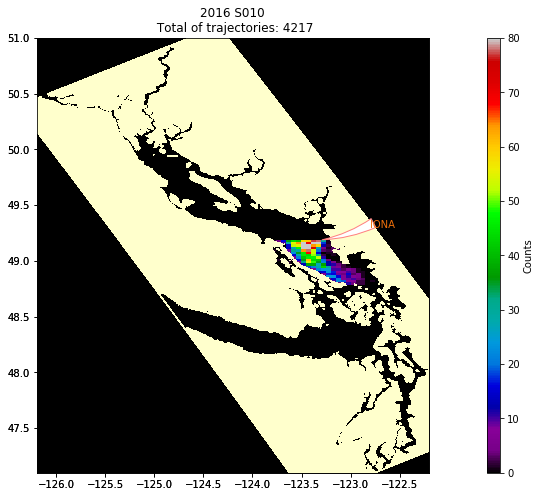

start:  2017-06-15 11:06:41.067300


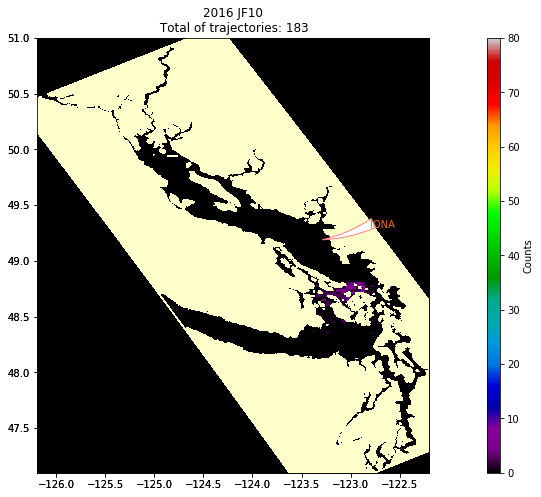

start:  2017-06-15 11:06:41.672683


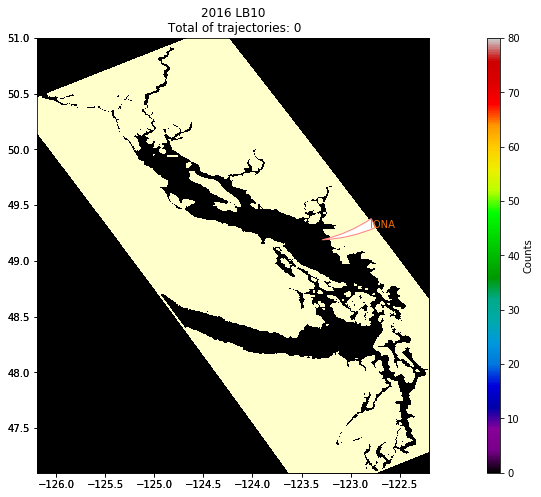

Sums for 10d per area:  {'NB': 0.0, 'N1': 143.0, 'N0': 20945.0, 'S0': 4217.0, 'JF': 183.0, 'LB': 0.0}


In [77]:
nday = 10

year_array = create_array(filesdir, nday)

areas = separate_points(year_array)
        


sums = {}
for area in areas.keys():

    title = ('2016 ' + area + str(nday)
    )

    sums [area] = plot(areas[area], title, "ok")
    
    plt.show()

plt.clf()

print ("Sums for {}d per area: ".format(nday), sums)

time_series = {}
time_series [nday] = sums
    

start:  2017-06-15 11:27:24.541524


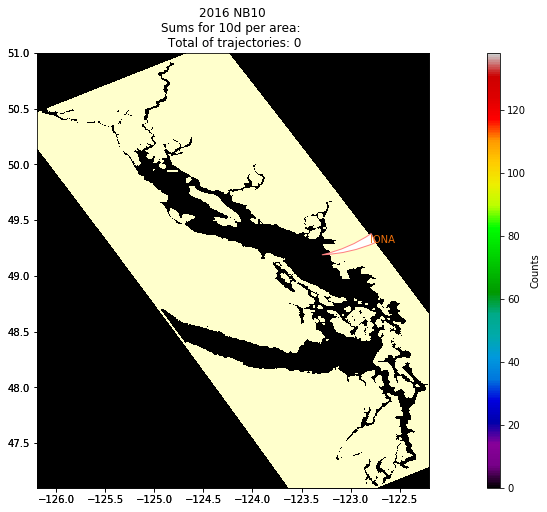

start:  2017-06-15 11:27:25.148251


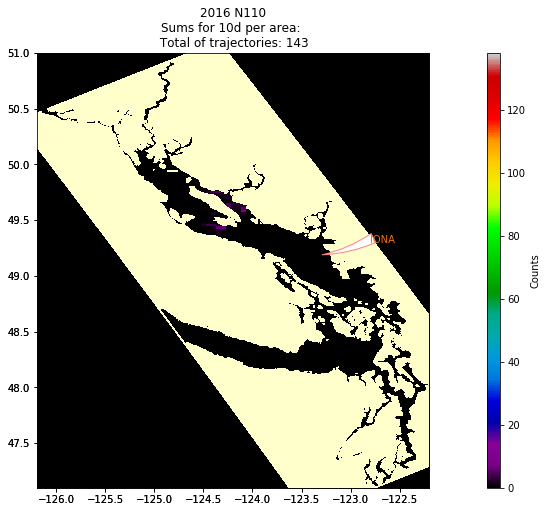

start:  2017-06-15 11:27:25.720898


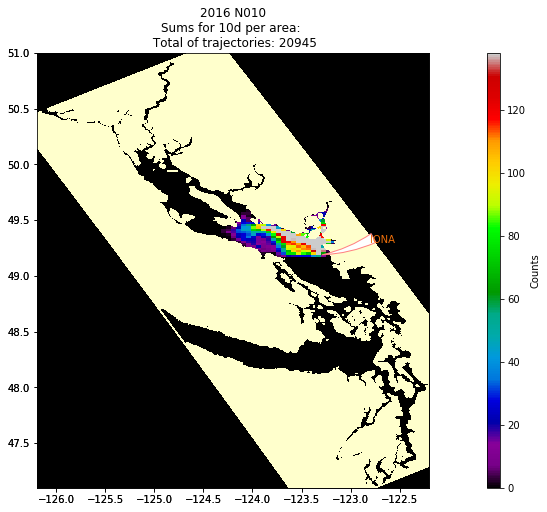

start:  2017-06-15 11:27:26.304684


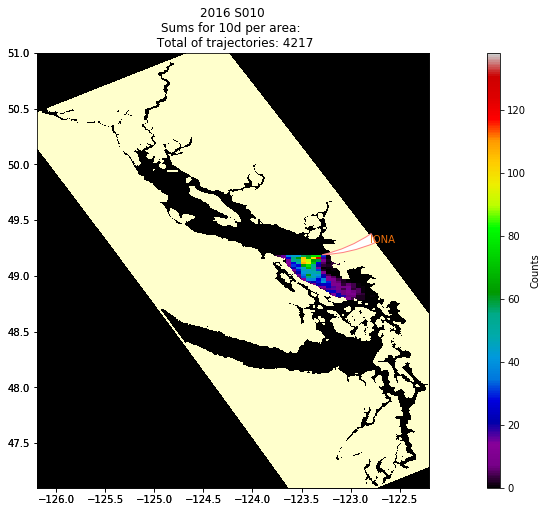

start:  2017-06-15 11:27:26.942781


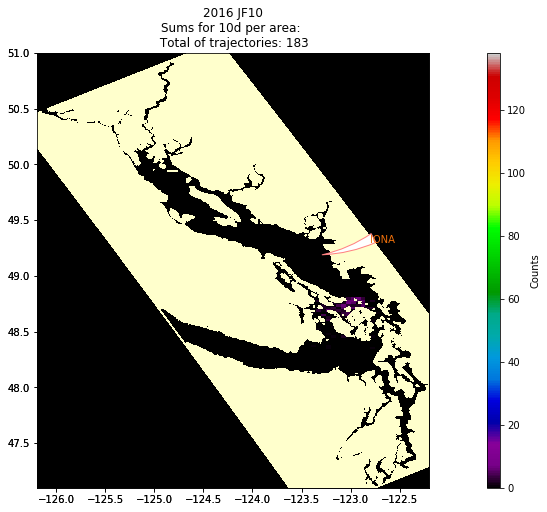

start:  2017-06-15 11:27:27.505260


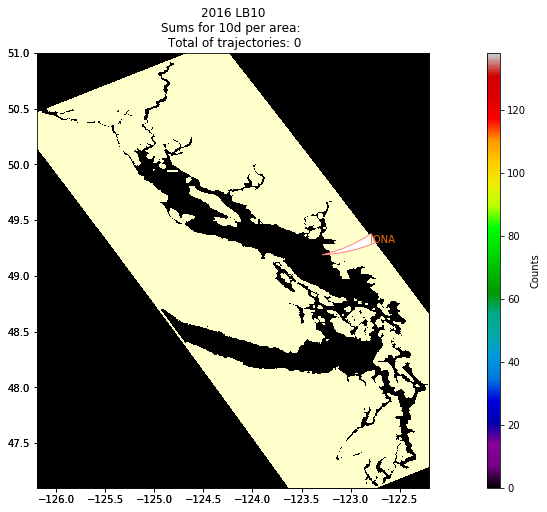

start:  2017-06-15 11:27:28.127600


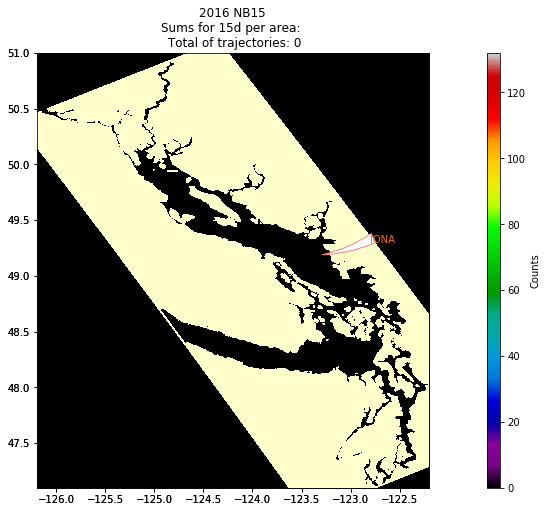

start:  2017-06-15 11:27:28.694972


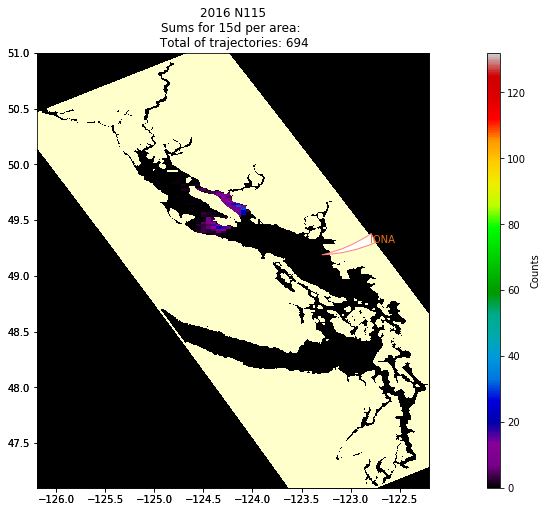

start:  2017-06-15 11:27:29.307004


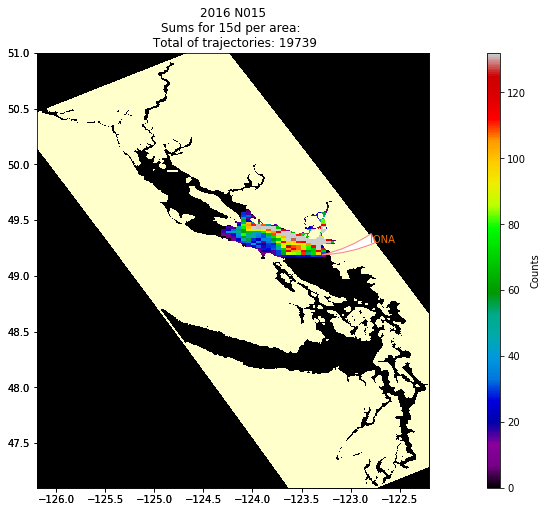

start:  2017-06-15 11:27:29.886130


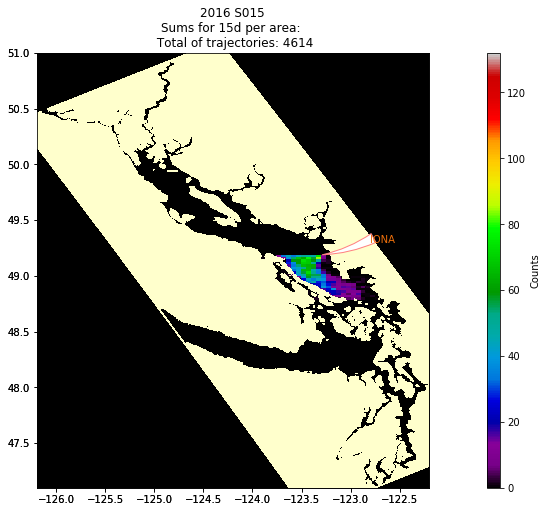

start:  2017-06-15 11:27:30.459325


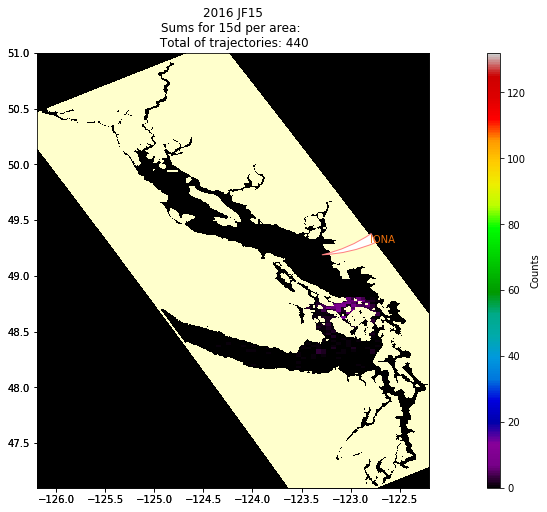

start:  2017-06-15 11:27:31.020866


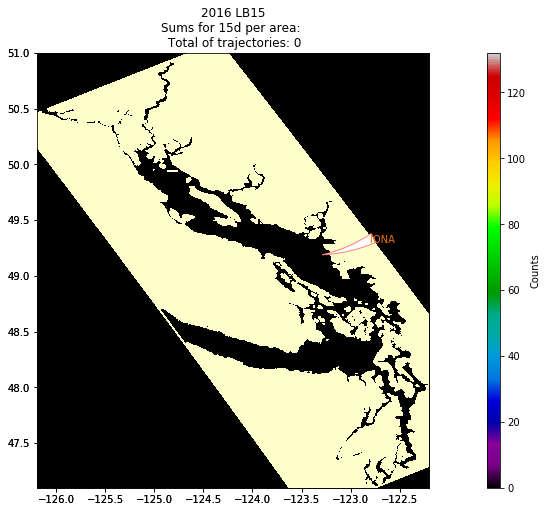

start:  2017-06-15 11:27:31.668463


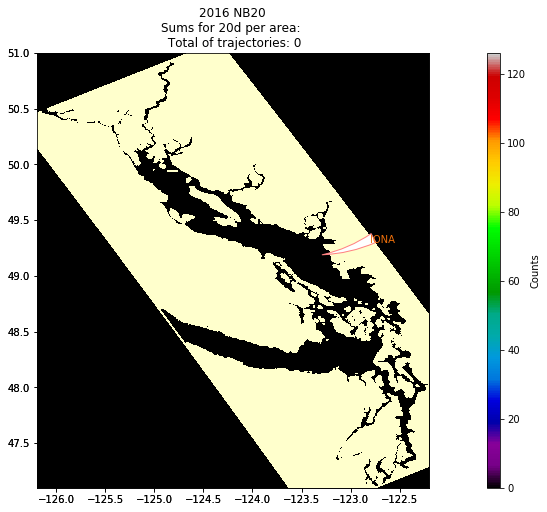

start:  2017-06-15 11:27:32.243692


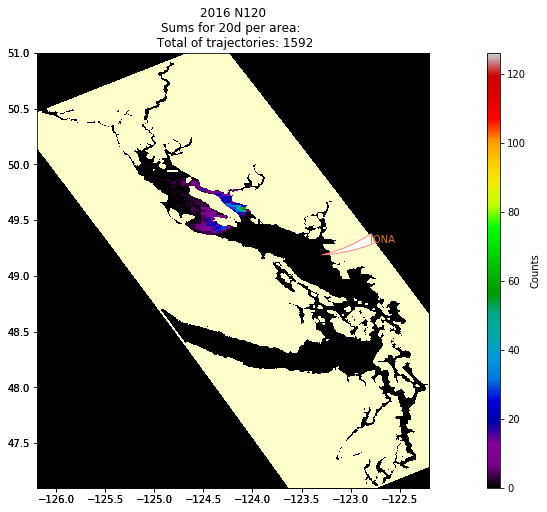

start:  2017-06-15 11:27:32.807642


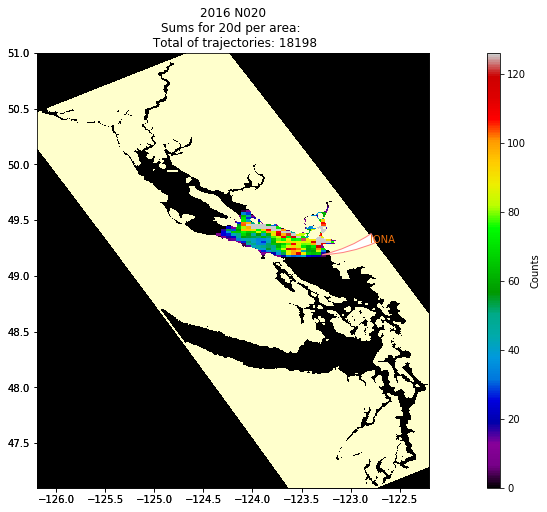

start:  2017-06-15 11:27:33.410715


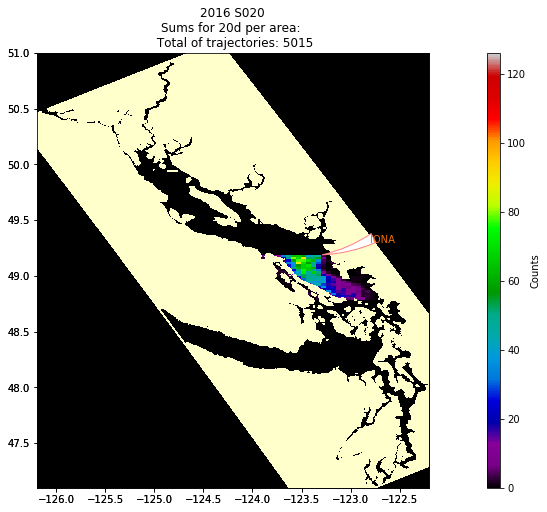

start:  2017-06-15 11:27:33.975616


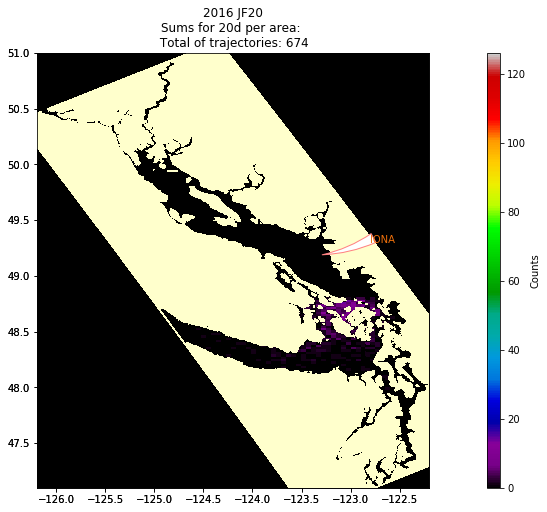

start:  2017-06-15 11:27:34.541584


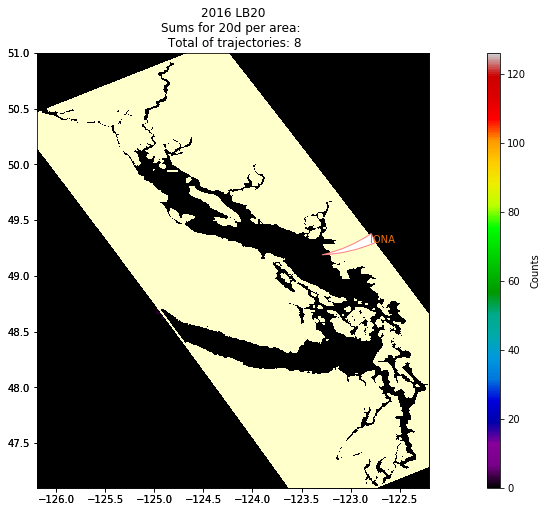

start:  2017-06-15 11:27:35.152053


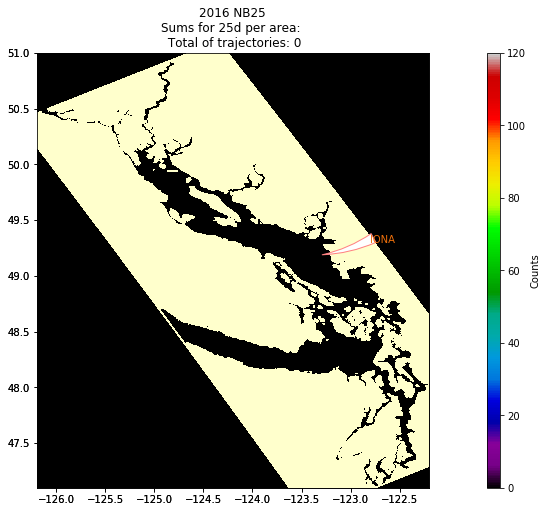

start:  2017-06-15 11:27:35.769628


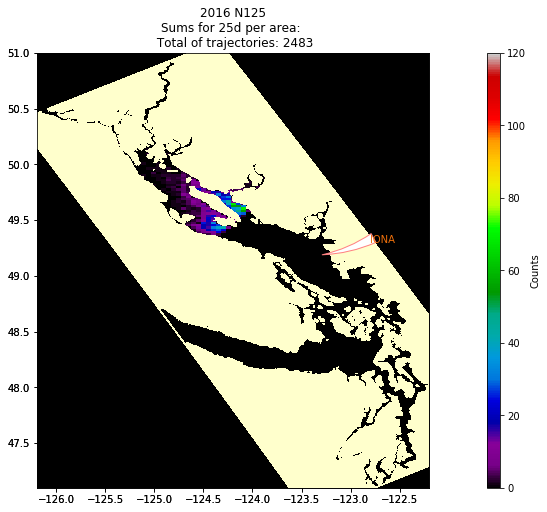

start:  2017-06-15 11:27:36.342296


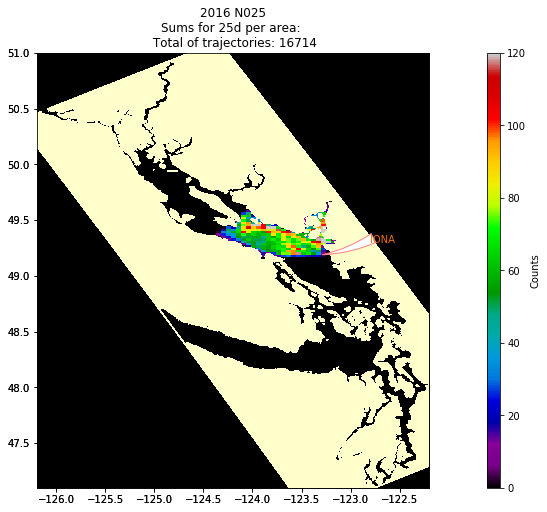

start:  2017-06-15 11:27:36.922225


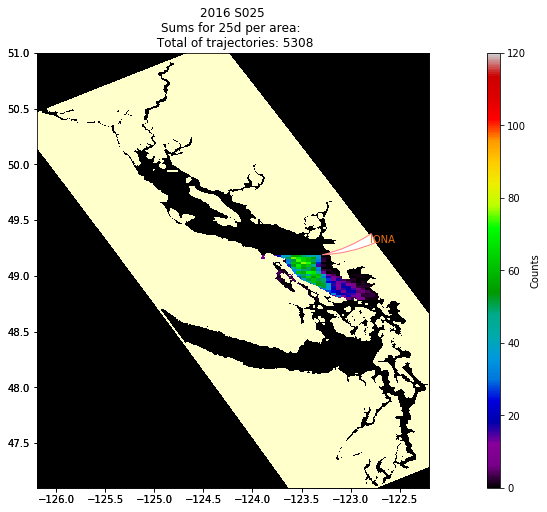

start:  2017-06-15 11:27:37.493249


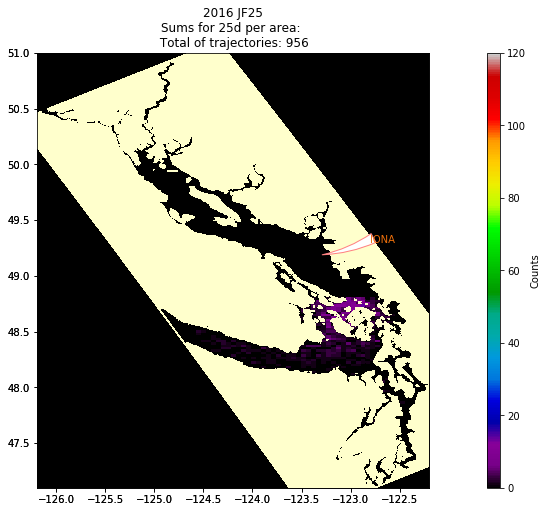

start:  2017-06-15 11:27:38.103215


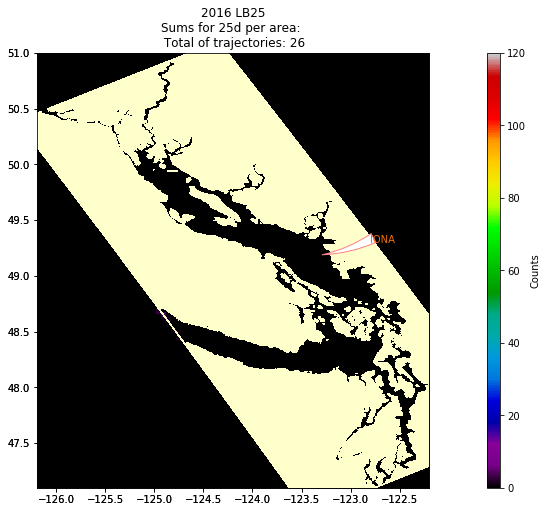

start:  2017-06-15 11:27:38.710433


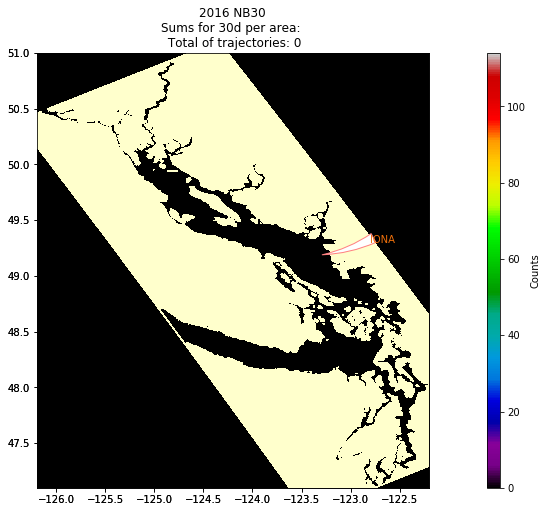

start:  2017-06-15 11:27:39.267207


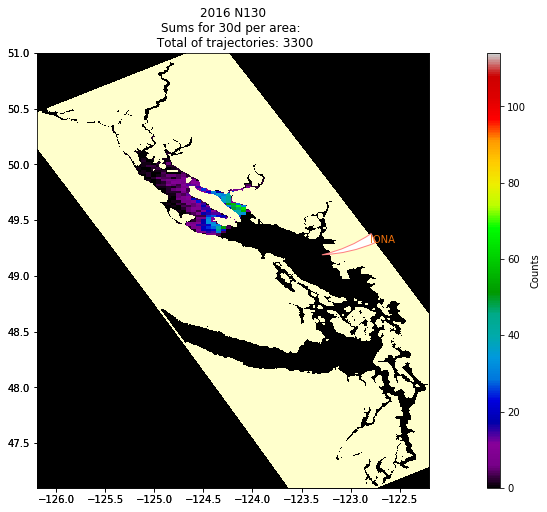

start:  2017-06-15 11:27:39.868768


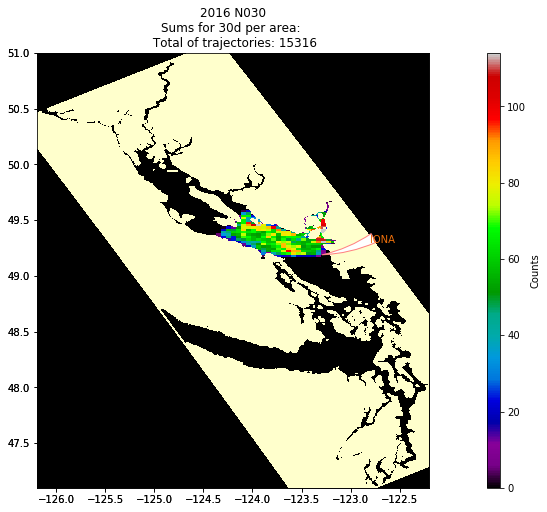

start:  2017-06-15 11:27:40.438114


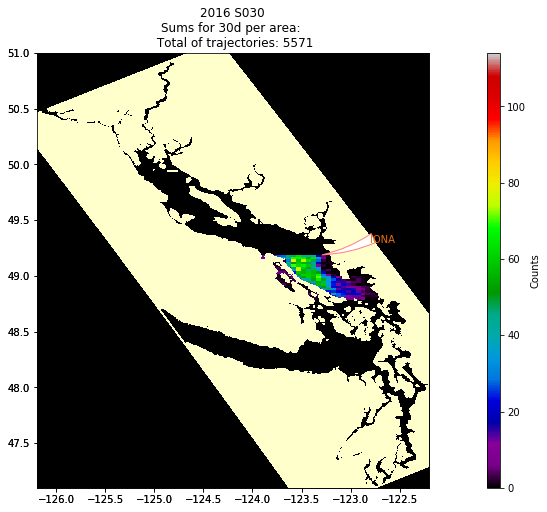

start:  2017-06-15 11:27:41.002936


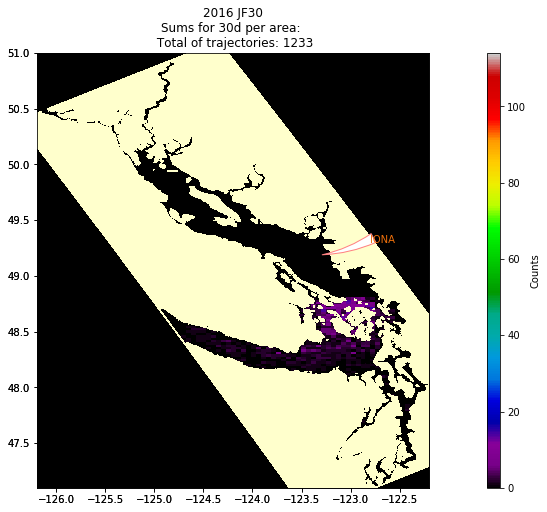

start:  2017-06-15 11:27:41.561571


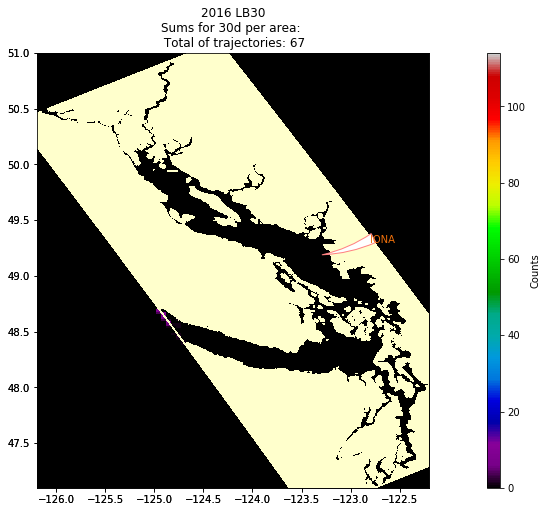

start:  2017-06-15 11:27:42.213293


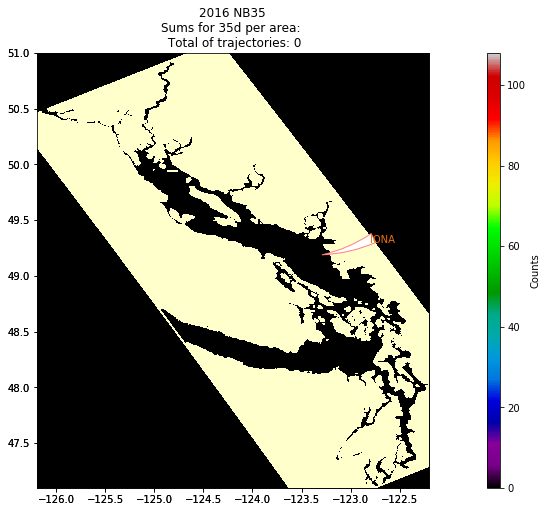

start:  2017-06-15 11:27:42.775343


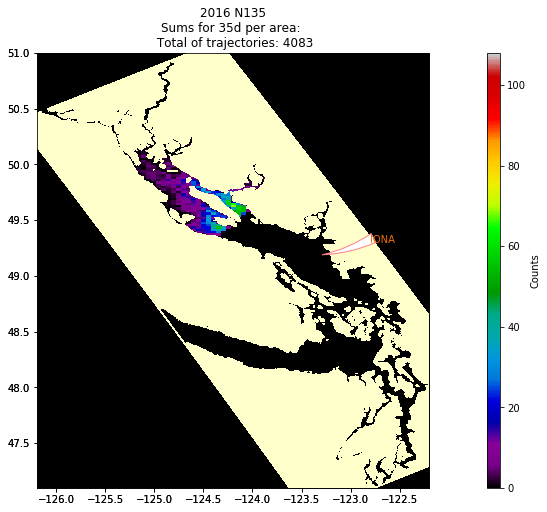

start:  2017-06-15 11:27:43.331325


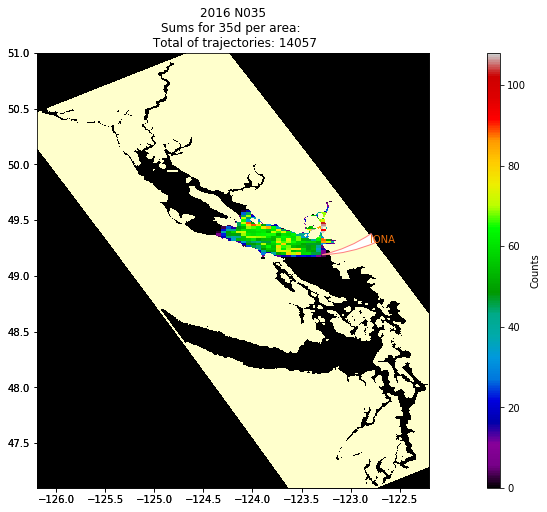

start:  2017-06-15 11:27:43.893795


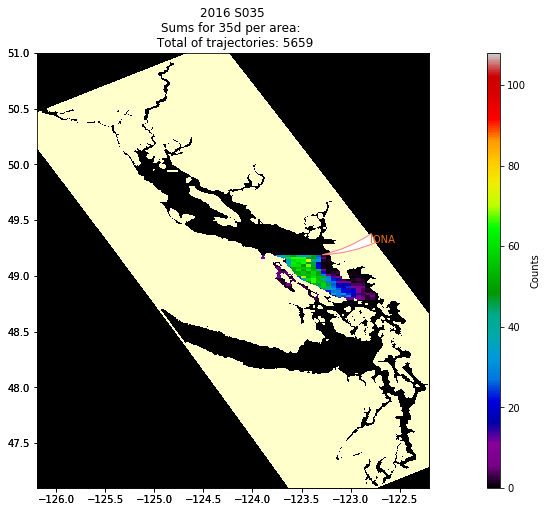

start:  2017-06-15 11:27:44.500258


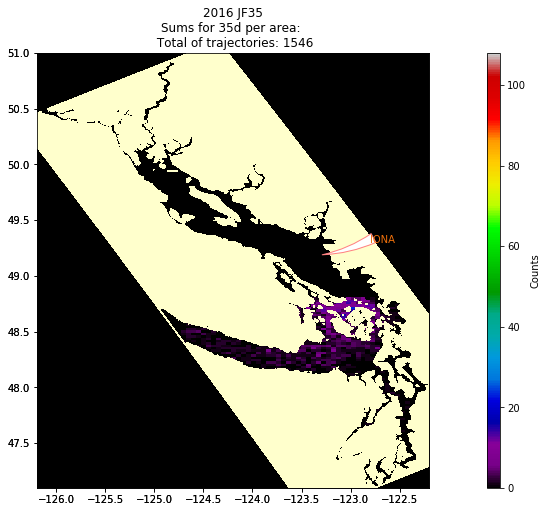

start:  2017-06-15 11:27:45.066123


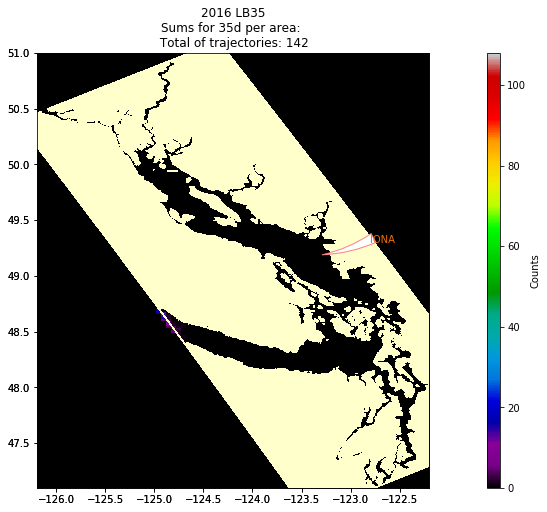

In [100]:
time_series = {}

for i in range (10, 36, 5):
    nday = i

    year_array = create_array(filesdir, nday)

    areas = separate_points(year_array)

    vmax = 150 - 1.2*nday

    sums = {}
    for area in areas.keys():
        
        

        title = ('2016 ' + area + str(nday) +'\n' +
                 "Sums for {}d per area: ".format(nday)
        )

        sums [area] = plot(areas[area], title, "ok")

        plt.show()

    plt.clf()



    time_series [str(nday)] = sums
    

In [101]:
print (time_series)

{'10': {'NB': 0.0, 'N1': 143.0, 'N0': 20945.0, 'S0': 4217.0, 'JF': 183.0, 'LB': 0.0}, '15': {'NB': 0.0, 'N1': 694.0, 'N0': 19739.0, 'S0': 4614.0, 'JF': 440.0, 'LB': 0.0}, '20': {'NB': 0.0, 'N1': 1592.0, 'N0': 18198.0, 'S0': 5015.0, 'JF': 674.0, 'LB': 8.0}, '25': {'NB': 0.0, 'N1': 2483.0, 'N0': 16714.0, 'S0': 5308.0, 'JF': 956.0, 'LB': 26.0}, '30': {'NB': 0.0, 'N1': 3300.0, 'N0': 15316.0, 'S0': 5571.0, 'JF': 1233.0, 'LB': 67.0}, '35': {'NB': 0.0, 'N1': 4083.0, 'N0': 14057.0, 'S0': 5659.0, 'JF': 1546.0, 'LB': 142.0}}


start:  2017-06-15 11:33:13.923938


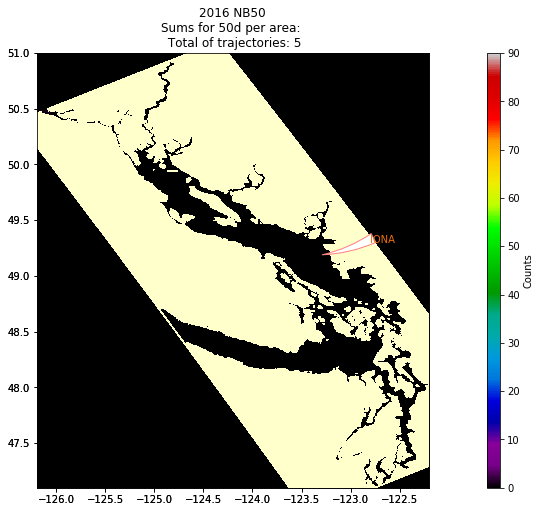

start:  2017-06-15 11:33:14.540723


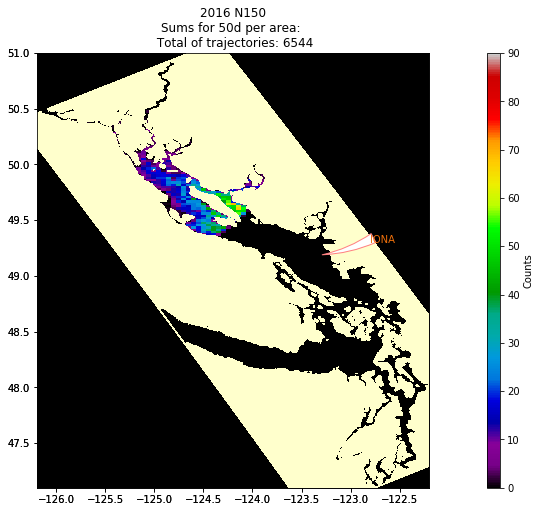

start:  2017-06-15 11:33:15.119731


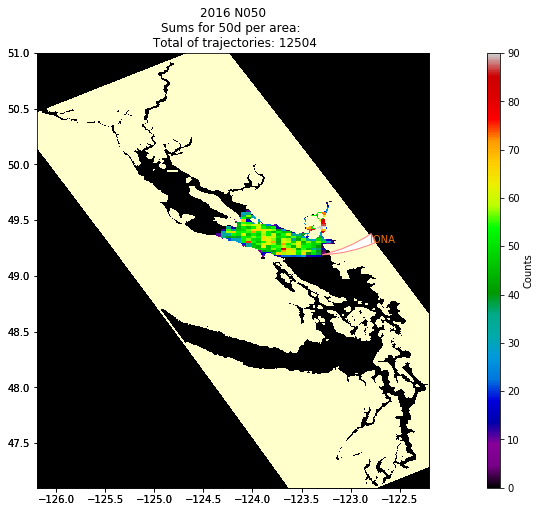

start:  2017-06-15 11:33:15.726208


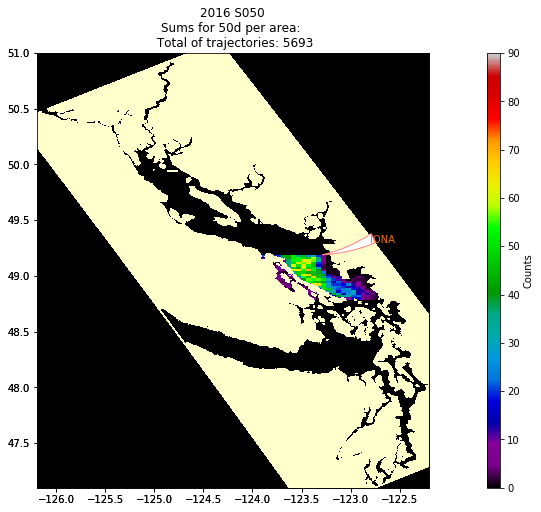

start:  2017-06-15 11:33:16.346612


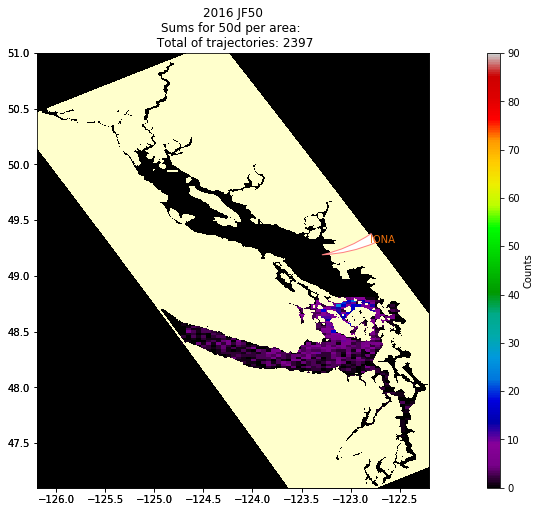

start:  2017-06-15 11:33:16.916131


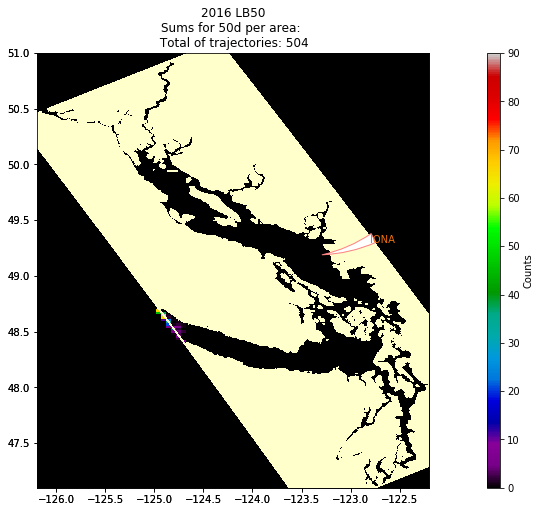

start:  2017-06-15 11:33:17.550507


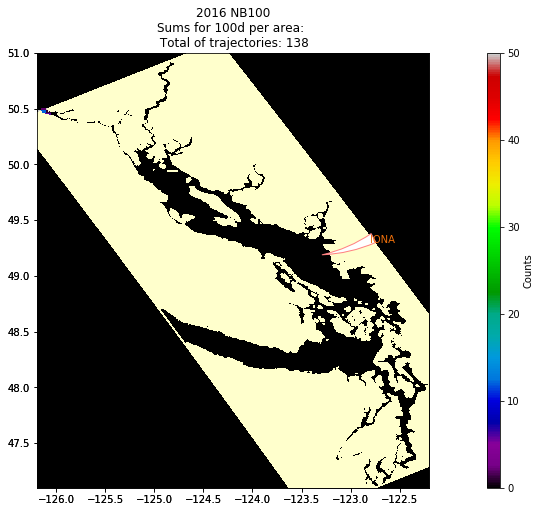

start:  2017-06-15 11:33:18.127766


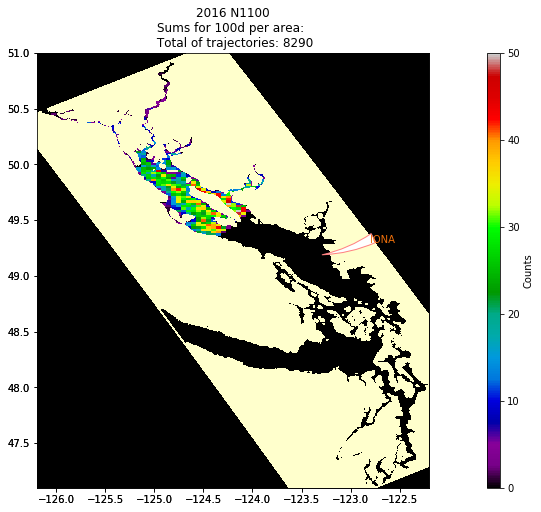

start:  2017-06-15 11:33:18.744536


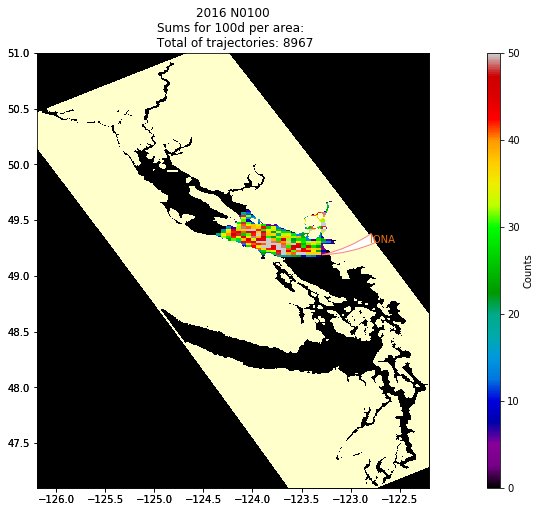

start:  2017-06-15 11:33:19.320090


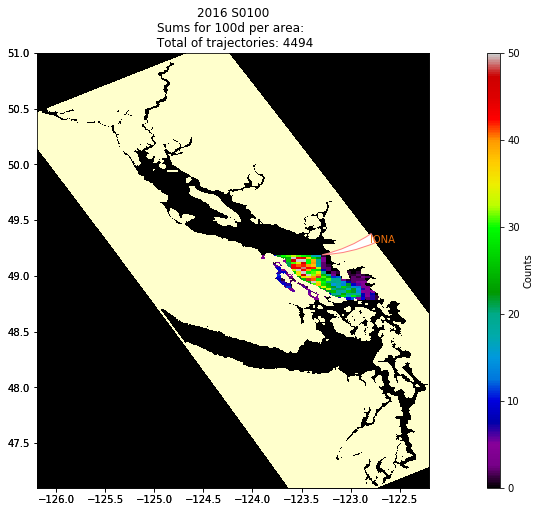

start:  2017-06-15 11:33:19.899865


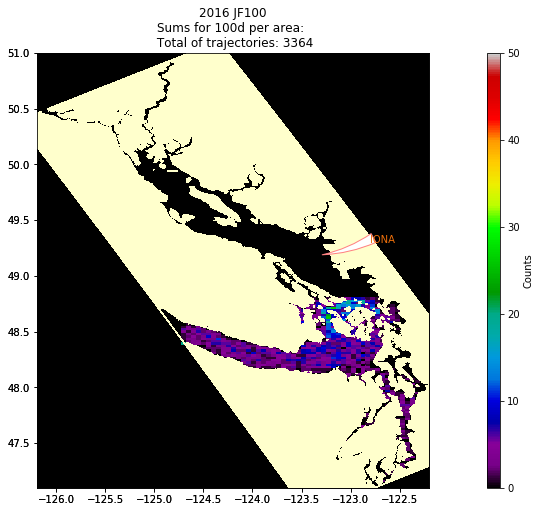

start:  2017-06-15 11:33:20.479867


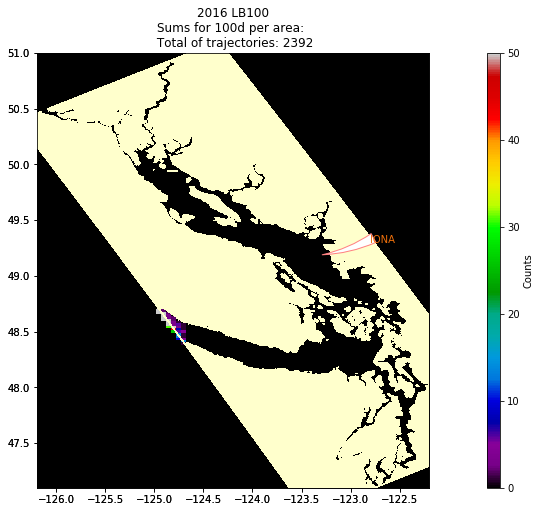

In [105]:
for i in (50, 100):
    nday = i

    year_array = create_array(filesdir, nday)

    areas = separate_points(year_array)

    vmax = 150 - 1.2*nday

    sums = {}
    for area in areas.keys():
        
        if i==100: vmax = 50
        
        

        title = ('2016 ' + area + str(nday) +'\n' +
                 "Sums for {}d per area: ".format(nday)
        )

        sums [area] = plot(areas[area], title, "ok")

        plt.show()

    plt.clf()



    time_series [str(nday)] = sums
    

10 0.0
15 0.0
20 0.0
25 0.0
30 0.0
35 0.0
50 5.0
100 138.0


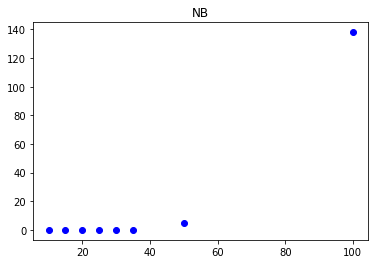

10 143.0
15 694.0
20 1592.0
25 2483.0
30 3300.0
35 4083.0
50 6544.0
100 8290.0


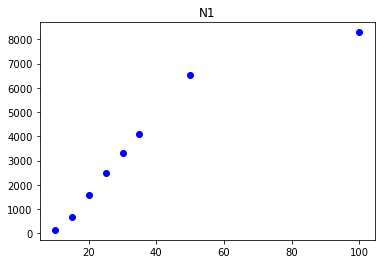

10 20945.0
15 19739.0
20 18198.0
25 16714.0
30 15316.0
35 14057.0
50 12504.0
100 8967.0


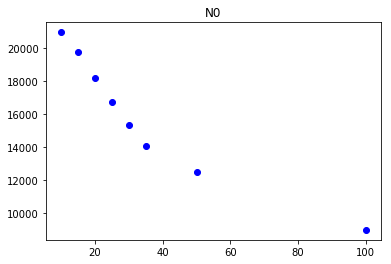

10 4217.0
15 4614.0
20 5015.0
25 5308.0
30 5571.0
35 5659.0
50 5693.0
100 4494.0


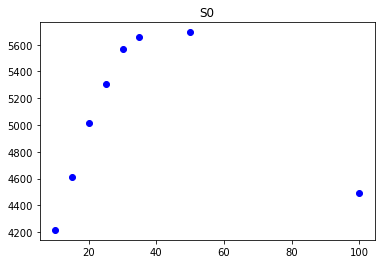

10 183.0
15 440.0
20 674.0
25 956.0
30 1233.0
35 1546.0
50 2397.0
100 3364.0


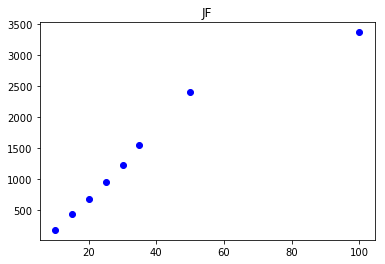

10 0.0
15 0.0
20 8.0
25 26.0
30 67.0
35 142.0
50 504.0
100 2392.0


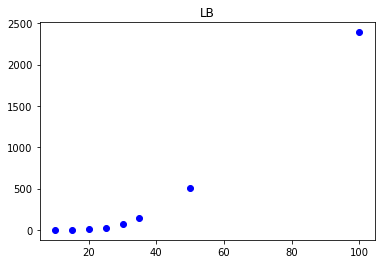

In [114]:
for area in areas.keys():

    for numday in time_series.keys():
        print (numday, time_series[numday][area])
        plt.title(area)
        plt.plot(numday, time_series[numday][area], 'bo')
    plt.show()
        